In [0]:
!pip install tensornets

     |████████████████████████████████| 593kB 9.5MB/s 
  Created wheel for tensornets: filename=tensornets-0.4.1-cp36-cp36m-linux_x86_64.whl size=1150413 sha256=e18fb87f7fa28fc47d83743b08d3b041192f16928d4a1a410ad4750afe01c7dc
  Stored in directory: /root/.cache/pip/wheels/f1/26/c3/65199c9bd510659df4eee92b9aeae24dbace5e78f8b7915560
Successfully built tensornets


Подключим традиционные библиотеки tensorflow, numpy. Далее мы будем использовать готовые сети из библиотеки tensornets и будем визуализировать их с помощью opencv (cv2). OpenCV обязателен для работы tensornets, так как через него оно как минимум делает преобразование изображений.

In [0]:
import tensorflow as tf
import tensornets as nets
import cv2
import numpy as np
import time
from google.colab.patches import cv2_imshow

Мы подключили библиотеку tensornets, где есть основные архитектуры сетей и наборы обыченных коэффициентов. Поэтому двумя строчками мы можем загрузить готовую модель YOLOv3.

In [0]:
inputs = tf.placeholder(tf.float32, [None, 416, 416, 3]) 
model = nets.YOLOv3COCO(inputs, nets.Darknet19)


Instructions for updating:
Please use `layer.__call__` method instead.





YOLO будет выдавать нам индекс класса, а не имя класса объекта, который она обнаружила. Поэтому нам надо найти таблицу соответствия индекса и класса, чтобы понимать что за объект сеть обнаружила. Это не так просто и хоть в интернете такие таблицы есть, но они разные, так как база COCO развивалась и выходили новые версии. Какую из них использовать?
Оказывается, что если порыться в пакете tensornets, то в dataset папке есть перечень классов COCO. Нехитрым дедуктивным методом через dir() и посмотрев код пакета, можно загрузить перечень классов. В описании tensornets я этой информации не нашёл.

In [0]:
import tensornets.datasets.coco as coco
print("There are {} classes in coco.classnames.".format(len(coco.classnames)))

There are 80 classes in coco.classnames.


Теперь научимся загружать картинки. Есть много способов, но нам нужна совместимость по типам с tensornets и чтобы не тратить много времени на согласование этих типов возьмём из примеров проекта tensornets на гитхабе их способ загрузки картинки. Проверим, что получилось нужное разрешение, которое должно быть 416х416х3, так как такие у нас входы сети выше.

In [0]:
imge = np.array(nets.utils.load_img('YOLO_test.jpg', target_size=416, crop_size=416))
print(imge[0])
print(imge.shape)

[[[229. 246. 254.]
  [229. 246. 254.]
  [229. 246. 254.]
  ...
  [191. 195. 202.]
  [188. 196. 202.]
  [191. 201. 208.]]

 [[229. 246. 254.]
  [229. 246. 254.]
  [229. 246. 254.]
  ...
  [190. 195. 202.]
  [188. 196. 202.]
  [190. 200. 207.]]

 [[230. 247. 255.]
  [230. 247. 255.]
  [230. 247. 255.]
  ...
  [190. 194. 201.]
  [187. 195. 202.]
  [190. 200. 206.]]

 ...

 [[151. 171. 195.]
  [137. 157. 181.]
  [ 88. 108. 130.]
  ...
  [ 71.  74.  89.]
  [ 73.  76.  91.]
  [ 77.  80.  95.]]

 [[143. 163. 187.]
  [152. 172. 196.]
  [109. 130. 152.]
  ...
  [ 69.  72.  87.]
  [ 66.  69.  84.]
  [ 64.  67.  82.]]

 [[119. 139. 163.]
  [120. 140. 164.]
  [109. 130. 152.]
  ...
  [ 70.  73.  88.]
  [ 59.  62.  77.]
  [ 51.  54.  69.]]]
(1, 416, 416, 3)


Нарисуем картинку с помощью opencv. Надо будет нажать любую клавишу, чтобы программа продолжилась. Это связано с особенностями opencv, когда картинка не отрисовывается, пока мы не ставим остановку средствами opencv. Для остановки выбрано ожидание нажатия клавиши. Также из формата дробных чисел нам нужно перейти в низкоуровневый формат восьмибитного представления цвета, да еще и поменять местами красный и синий каналы, так как opencv в отличие от остальных использует BGR формат.

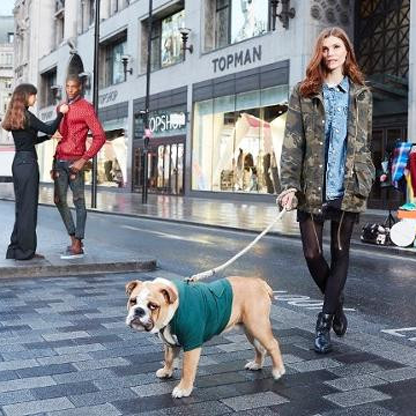

In [0]:
img_to_show = cv2.cvtColor(np.uint8(imge[0]), cv2.COLOR_RGB2BGR)
cv2_imshow(img_to_show)

Итак, мы видим что собрались распознавать. У нас есть картинка для визуализации, а также картинка для передачи на поиск объектов. Сделаем его, как это сделано в примере в readme.md в репозитории tensornets. В итоге мы получим рамки вокруг объектов в виде массива. Номер массива соответствует классу.

In [0]:
with tf.Session() as sess:
    sess.run(model.pretrained())
    imge = model.preprocess(imge)  # equivalent to img = nets.preprocess(model, img)
    preds = sess.run(model.preds, {inputs: imge})
    boxes = np.array(model.get_boxes(preds, imge.shape[1:3]))
    #print(boxes)

Мы видим структуру полей в рамках - это массив классов, где класс это массив экземпляров, где экземпляр это 4 координаты рамки и степень уверенности. Уберем лишнее и дадим имена этим классам. Перебираем их в цикле. Сделаем это по питоновски, через enumerate.

In [0]:
for index, cls in enumerate(coco.classnames):
    if len(boxes[index]) == 0:
        continue
    for obj_box in boxes[index]:
        print("Found class {} in region {} with certainty {:.2f}.".format(cls, obj_box[0:4], obj_box[4]))

Found class person in region [406. 137. 415. 206.] with certainty 0.45.
Found class person in region [  3.  76.  56. 257.] with certainty 0.99.
Found class person in region [ 44.  72. 106. 254.] with certainty 1.00.
Found class person in region [394. 138. 414. 204.] with certainty 0.66.
Found class person in region [383. 144. 408. 212.] with certainty 0.11.
Found class person in region [275.  25. 380. 345.] with certainty 0.99.
Found class dog in region [115. 277. 295. 393.] with certainty 1.00.


Найдено 6 человек и одна собака. Многовато людей. Теперь бы увидеть где эти люди. Для этого проще всего эти рамки нарисовать на кадре и вывести его на экран. Рисовать можно средствами opencv. Сделаем снова перебор классов, как раньше, но с рисованием рамок и имени класса.

Found class person in region [406. 137. 415. 206.] with certainty 0.45.
Found class person in region [  3.  76.  56. 257.] with certainty 0.99.
Found class person in region [ 44.  72. 106. 254.] with certainty 1.00.
Found class person in region [394. 138. 414. 204.] with certainty 0.66.
Found class person in region [383. 144. 408. 212.] with certainty 0.11.
Found class person in region [275.  25. 380. 345.] with certainty 0.99.
Found class dog in region [115. 277. 295. 393.] with certainty 1.00.


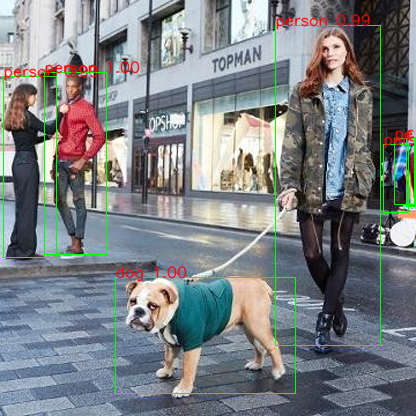

In [0]:
for index, cls in enumerate(coco.classnames):
    if len(boxes[index]) == 0:
       continue
    for obj_box in boxes[index]:
        cv2.rectangle(img_to_show,(obj_box[0],obj_box[1]),(obj_box[2],obj_box[3]),(0,255,0),1)
        cv2.putText(img_to_show, "{} {:.2f}".format(cls, obj_box[4]), (obj_box[0],obj_box[1]), cv2.FONT_HERSHEY_SIMPLEX, .5, (0, 0, 255), lineType=cv2.LINE_AA)
        print("Found class {} in region {} with certainty {:.2f}.".format(cls, obj_box[0:4], obj_box[4]))
cv2_imshow(img_to_show)

В углу картинки найдено 3 человека, которых нет. Давайте объединим всё сделанное в функцию от картинки до рисования рамок. Это предлагается сделать самостоятельно. Она будет получать сессию tensorflow, считанную картинку, порог уверенности в найденном объекте, перечень классов, а выдавать картинку, где эти объекты обведены рамкой, подписан класс и указана степень уверенности.

In [0]:
def yolo(sess, image, threshold, classnames):
    img_to_show = cv2.cvtColor(np.uint8(image[0]), cv2.COLOR_RGB2BGR)
    image = model.preprocess(image)  # equivalent to img = nets.preprocess(model, img)
    preds = sess.run(model.preds, {inputs: image})
    boxes = np.array(model.get_boxes(preds, image.shape[1:3]))
    for index, cls in enumerate(classnames):
        if len(boxes[index]) == 0:
            continue
        for obj_box in boxes[index]:
            if obj_box[4] > threshold:
                cv2.rectangle(img_to_show,(obj_box[0],obj_box[1]),(obj_box[2],obj_box[3]),(0,255,0),1)
                cv2.putText(img_to_show, "{} {:.2f}".format(cls, obj_box[4]), (obj_box[0],obj_box[1]), cv2.FONT_HERSHEY_SIMPLEX, .5, (0, 0, 255), lineType=cv2.LINE_AA)
                print("Found class {} in region {} with certainty {:.2f}.".format(cls, obj_box[0:4], obj_box[4]))
    return img_to_show

Для вызова этой функции заново считаем изображение (на всякий случай, ведь мы эту переменную уже переприсваивали), создадим сессию, запустим в ней модель и вызовем нашу функцию. Результат нарисуем. Такая схема вызова позволит обрабатывать несколько кадров, не прерывая сессии.

Found class person in region [  3.  76.  56. 257.] with certainty 0.99.
Found class person in region [ 44.  72. 106. 254.] with certainty 1.00.
Found class person in region [275.  25. 380. 345.] with certainty 0.99.
Found class dog in region [115. 277. 295. 393.] with certainty 1.00.


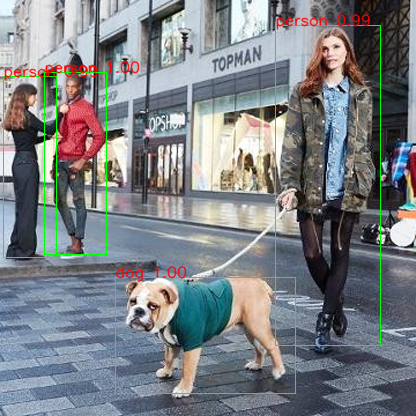

In [0]:
imge = np.array(nets.utils.load_img('YOLO_test.jpg', target_size=416, crop_size=416))
with tf.Session() as sess:
    sess.run(model.pretrained())
    result = yolo(sess, imge, 0.7, coco.classnames)

cv2_imshow(result)

Мы умеем распознавать отдельные кадры, подписывать на них нужные данные, ну а теперь распознаем видео! Кадры видео мы будем получать с помощью opencv в виду трёхмерных массивов, так что их надо будет преобразовать к четырёхмерным типа numpy. Также теперь они считываются средствами opencv, так что они сразу в BGR формате и надо его привести к обычному RGB для распознавания.

In [0]:
def crop_square(img):
   
    width = img.shape[1]
    height = img.shape[0]

    new_width = min(width, height)

    new_height = min(width, height)

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img

Все кадры распознаются и дополняются данными распознавания. Однако видно, что непрямоугольное изначальное видео сжимается и нарушаются пропорции. Сделай (найди в интернете) функцию откидывания боковых сторон прямоугольника изображения, чтобы оставалась квадратная область. Перезапусти распознавание видео и посмотри стали ли выше вероятности распознавания.

In [ ]:
with tf.Session() as sess:
    sess.run(model.pretrained())    
    cap = cv2.VideoCapture("yolo_video.webm")
    while(cap.isOpened()): #change the path to your directory or to '0' for webcam
        ret, frame = cap.read()
        if(not ret):
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = crop_square(frame)
        image_to_show = cv2.resize(frame,(416,416))
        imge = np.array(image_to_show).reshape(-1,416,416,3)
        img = yolo(sess, imge, 0.7, coco.classnames)
        cv2_imshow(img)  
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break